In [5]:
# This will improve in the future so plotting is accessible to all!

import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import curve_fit
from scipy import stats
from scipy.interpolate import interp1d

import seaborn as sns
from ipywidgets import *
# Apply the default theme
#sns.set_theme(palette='bright')
# Set white background
sns.set_style("whitegrid")

#from parameters import *
#import save_n_load as sl

I_10KPC = {"LIVERMORE": 2684, "GKVM": 3295, "GARCHING": 882} # Number of expected events at 10 kpc for a 40 kton LArTPC

In [2]:
# Parameters to get the desired curve(s) (feel free to change them to anything you have already computed)
fake_trigger_rate = FAKE_TRIGGER_RATE
burst_time_window = BURST_TIME_WINDOW
distance_to_evaluate = distance_to_evaluate
sim_mode = SIM_MODE
adc_mode = ADC_MODE
detector = DETECTOR
classify = CLASSIFY
average_energy = AVERAGE_ENERGY
alpha = ALPHA

sim_parameters = [fake_trigger_rate, burst_time_window, distance_to_evaluate, sim_mode, adc_mode, detector, classify, average_energy, alpha]
file_name = None

In [ ]:
# Or just specify the filename(s)
sim_parameters = []
file_name = "wahtevs.pcl"

In [3]:
%matplotlib widget
# Load the curves

sim_parameters_list = []
models = ["GKVM", "LIVERMORE", "GARCHING"]
energies = [23.0, 14.4, 14.4]
alphas = [5.0, 2.8, 2.8]
dtos = [20, 20, 20]
dtos = [20.01, 20.01, 20.01]

for i, model in enumerate(models):
    sim_parameters_list.append([fake_trigger_rate, burst_time_window, dtos[i], sim_mode, adc_mode, detector, classify, energies[i], alphas[i]])

for i, simp in enumerate(sim_parameters_list):
    
    eff_data, _ = sl.load_efficiency_data(simp, file_name, data_type="data")
    
    print(eff_data[1], eff_data[2], eff_data[0])
    
    eff_curve_data, _ = sl.load_efficiency_data(simp, file_name, data_type="curve")
    distances = eff_curve_data[0]
    efficiencies = eff_curve_data[1]

    # All efficiency curves are calculated with the Livermore event number normalization. 
    # This is not a problem, we can normalize to whatever we want now.
    # For example:
    norm = I_10KPC[models[i]]
    gkvm_distances = np.array(distances) * np.sqrt(norm/I_10KPC["LIVERMORE"])

    plt.plot(gkvm_distances, efficiencies, label=models[i])
    plt.scatter(gkvm_distances, efficiencies, s=14)
    
    # Get the value of the curve at a given distance
    linear_interp = interp1d(gkvm_distances, efficiencies, kind='linear')
    print("EFF at 10 kpc:", linear_interp(10))
    print("EFF at 15 kpc:", linear_interp(15))
    print("EFF at 20 kpc:", linear_interp(20))
    
    # Get the 90% threshold
    interval = np.linspace(6, 30, 3000)
    diff = np.diff(interval)[0]
    for x in interval:
        if linear_interp(x) < 0.90 and linear_interp(x-diff) > 0.90:
            print("95% thresh at:", x)
            break

plt.xlabel("Distance (kpc)")
plt.ylabel("Trigger efficiency")
plt.legend()

Loaded efficiency data from file efficiency_data_NWS1CH0N.pcl
(0.19, 0.11, 260, 25000, 20000, 30000, 20.01, 0.95) 9 1.0
Loaded efficiency curve from file efficiency_curve_5PEYTOIN.pcl


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

EFF at 10 kpc: 1.0
EFF at 15 kpc: 1.0
EFF at 20 kpc: 1.0
95% thresh at: 28.55951983994665
Loaded efficiency data from file efficiency_data_4XKKIU2S.pcl
(0.17, 0.11, 270, 25000, 20000, 30000, 20.01, 0.97) 10 0.52
Loaded efficiency curve from file efficiency_curve_LNHM4C8D.pcl
EFF at 10 kpc: 1.0
EFF at 15 kpc: 0.9541666666666666
EFF at 20 kpc: 0.49166666666666664
95% thresh at: 16.123374458152718
Loaded efficiency data from file efficiency_data_4XKKIU2S.pcl
(0.17, 0.11, 270, 25000, 20000, 30000, 20.01, 0.97) 10 0.52
Loaded efficiency curve from file efficiency_curve_LNHM4C8D.pcl
EFF at 10 kpc: 0.7584266962271284
EFF at 15 kpc: 0.06694475136132988
EFF at 20 kpc: 0.0060185425904311
95% thresh at: 9.24108036012004


## Pinched fluxes
$\phi\left(E_{\nu}\right)=\mathcal{N}\left(\frac{E_{\nu}}{\left\langle E_{\nu}\right\rangle}\right)^{\alpha} \exp \left[-(\alpha+1) \frac{E_{\nu}}{\left\langle E_{\nu}\right\rangle}\right]$

interactive(children=(FloatSlider(value=3.0, description='alpha', max=10.0), FloatSlider(value=10.0, descripti…

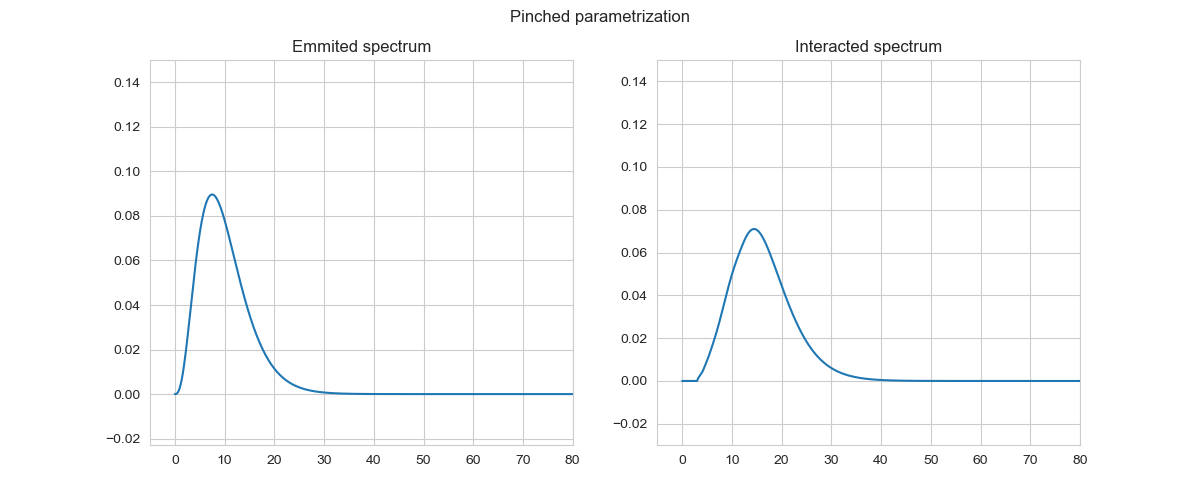

In [7]:
%matplotlib widget
xsec_sg_path = "../snowglobes/xscns/"
marley_1 = np.genfromtxt(xsec_sg_path + "xs_nue_Ar40.dat", skip_footer=0)
sng = np.genfromtxt(xsec_sg_path + "xs_nue_Ar40_marley2.dat", skip_footer=0)

log_e, xsec = marley_1[:, 0], marley_1[:, 1]
log_e_sg, xsec_sg = sng[:, 0], sng[:, 1]
e = 10**log_e * 1000
e_sg = 10**log_e_sg

def pinched_spectrum(energies, average_e, alpha):
    spectrum = (energies/average_e)**alpha * np.exp(- (alpha + 1) * energies/average_e)
    norm = np.sum(spectrum * np.diff(energies)[0])
    return spectrum/norm

energies_p = np.arange(0, 100, 0.2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Pinched parametrization")

line_0, = ax[0].plot(energies_p, pinched_spectrum(energies_p, 3, 10))
ax[0].set_ylim(top=0.15)
ax[0].set_xlim(right=80)
ax[0].set_title("Emmited spectrum")

#plt.plot(flux_e, flux_spec/flux_norm)

# --------------------------------------------------------------------------------

xsec_interp = np.interp(energies_p, e, xsec)
interacted_spectrum = pinched_spectrum(energies_p, 3, 10) * xsec_interp
norm = np.sum(interacted_spectrum * np.diff(energies_p)[0])
line_1, = ax[1].plot(energies_p, interacted_spectrum / norm)

ax[1].set_ylim(top=0.15)
ax[1].set_xlim(right=80)
ax[1].set_title("Interacted spectrum")
#ax[1].plot(sg_pinched_energies, sg_pinched_spectrum/sg_pinched_norm, label="GKVM SNOwGLoBES")

def update_2(alpha = 3.0, average_e = 10.0):
    line_0.set_ydata(pinched_spectrum(energies_p, average_e, alpha))
    fig.canvas.draw_idle()

    interacted_spectrum = pinched_spectrum(energies_p, average_e, alpha) * xsec_interp
    norm = np.sum(interacted_spectrum * np.diff(energies_p)[0])
    line_1.set_ydata(interacted_spectrum / norm)
    fig.canvas.draw_idle()
interact(update_2, alpha=(0.0, 10.0, 0.1), average_e=(0.1, 40.0, 0.1));

## Distance to event number (and viceversa)

In [13]:
import aux

distance = 21
model = "GARCHING"
event_num = aux.distance_to_event_number(distance, model, tpc_size=12)

print(event_num)

60.0


In [12]:
event_num = 60
model = "GARCHING"
distance = aux.event_number_to_distance(event_num, model, tpc_size=12)

print(distance)

21.0


In [16]:
from scipy import stats

r = stats.poisson.rvs(30, size=10)
print(r)

[31 23 36 30 24 20 36 30 33 24]
